In [1]:

# Set up notebook
%pprint
%matplotlib inline
import sys
import os.path as osp, os as os

executable_path = sys.executable
scripts_folder = osp.join(osp.dirname(executable_path), 'Scripts'); assert osp.exists(scripts_folder)
py_folder = osp.abspath(osp.join(os.pardir, 'py')); assert osp.exists(py_folder), "Create the py folder"
ffmpeg_folder = r'C:\ffmpeg\bin'; assert osp.exists(ffmpeg_folder)
shared_folder = osp.abspath(osp.join(os.pardir, 'share')); assert osp.exists(shared_folder)
scripts312_folder = r'C:\Users\daveb\AppData\Roaming\Python\Python312\Scripts'; assert osp.exists(scripts312_folder)

if (scripts_folder not in sys.path): sys.path.insert(1, scripts_folder)
if (py_folder not in sys.path): sys.path.insert(1, py_folder)
if (ffmpeg_folder not in sys.path): sys.path.insert(1, ffmpeg_folder)
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
if (scripts312_folder not in sys.path): sys.path.insert(1, scripts312_folder)

from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join(os.pardir, 'data')),
    saves_folder_path=osp.abspath(osp.join(os.pardir, 'saves'))
)
nu.delete_ipynb_checkpoint_folders()

Pretty printing has been turned OFF


In [2]:

# Download all the vector and raster map data from Natural Earth
import geopandas as gpd

# Read in the zip file of everything
file_path = osp.abspath(osp.join(nu.data_folder, 'zip', 'ne_10m_admin_0_countries.zip'))
countries_df = gpd.read_file(file_path)

In [3]:

# Get a hand-valued dictionary of font sizes for each country
fontsize_dict = {
    'Iran': 140,
    'Turkey': 82,
    'Iraq': 76,
    'Egypt': 60,
    'Yemen': 50,
    'Saudi Arabia': 46,
    'Oman': 36,
    'Syria': 36,
    'Jordan': 18,
    'Israel': 8,
    'Kuwait': 8,
    'United Arab Emirates': 6,
    'Lebanon': 5,
    'Qatar': 4,
    'Bahrain': 1,
}

In [4]:

# Move the ocean to the front of this list eventually
country_names = sorted(fontsize_dict.keys())

# Get a tupled list of (convex) country boundary areas
mask_series = countries_df.NAME_EN.isin(country_names)
country_areas = []
for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):
    bounds_tuple = geometry.bounds
        
    # Bounds Breakdown:
    minx = bounds_tuple[0]
    miny = bounds_tuple[1]
    maxx = bounds_tuple[2]
    maxy = bounds_tuple[3]
    
    # Rectangle Parameters:
    width = maxx - minx
    height = maxy - miny

    # Boundary area creation
    country_area = width * height
    
    area_tuple = (country_name, country_area)
    country_areas.append(area_tuple)
country_areas = sorted(country_areas, key=lambda x: x[1], reverse=True)
country_areas

[('Saudi Arabia', 331.7788232081368), ('Iran', 284.01399394254867), ('Turkey', 120.20356206680844), ('Egypt', 117.98247035326742), ('Yemen', 82.57279020407178), ('Iraq', 81.33432328579566), ('Oman', 76.64253424717411), ('Syria', 33.34787577668872), ('Jordan', 18.1596585328054), ('United Arab Emirates', 16.627817659608485), ('Israel', 6.422839435348814), ('Kuwait', 2.9734908882563205), ('Lebanon', 2.455264542634866), ('Qatar', 1.3850950067221495), ('Bahrain', 0.31085804838628295)]


## Get some good country colors

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.35s/it]


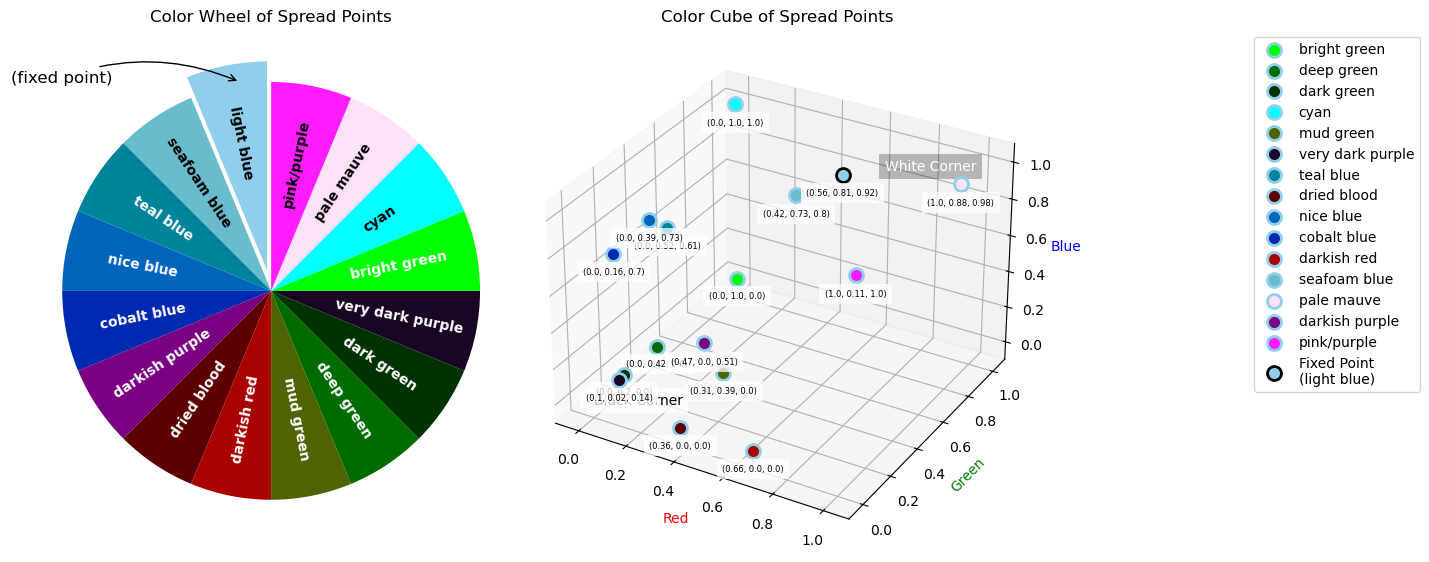

In [5]:

from tqdm import tqdm
from colormath.color_objects import LabColor

# Get a fixed point in the CIELAB color space
ranges = [(0, 100), (-128, 127), (-128, 127)]
ocean_color = (0.5294117647058824, 0.807843137254902, 0.9215686274509803)  # light blue
fixed_point = nu.rgb_to_lab(ocean_color).get_value_tuple()

# Get additional points to spread
point_count = len(fontsize_dict)

# Initialize a list to store trial results
trials = []
total_trials = 5  # Adjust this based on your patience

# Perform trials to find the best spread of points
with tqdm(total=total_trials) as pbar:
    while len(trials) < total_trials:
        
        # Attempt to spread the points evenly within the color space
        try:
            spread_points = nu.spread_points_in_cube(
                point_count, fixed_point, *ranges, verbose=False
            )

            # Ensure spread points have all unique XKCD names
            xkcd_set = set()
            for lab_color in spread_points:
                rgb_color = nu.lab_to_rgb(LabColor(*lab_color))
                nearest_neighbor = nu.get_nearest_neighbor(rgb_color, nu.xkcd_colors)
                xkcd_set.add(nu.nearest_xkcd_name_dict[nearest_neighbor])
            if len(xkcd_set) == len(spread_points):
                
                # Measure how far the points are from the fixed point
                spread_value = nu.calculate_spread(spread_points[1:], fixed_point, verbose=False)
                
                # Store the result as a tuple of (spread_points, spread_value)
                trial_tuple = (spread_points, spread_value)
                trials.append(trial_tuple)  # Add a new trial
                
                # Update the progress bar
                pbar.update(1)  # Increment the progress bar by 1
        
        # If an error occurs (e.g., a spread point too close to black or white), skip this trial
        except Exception:
            continue
    
# Select the trial with points as far away from the fixed point as possible
trial_tuple = max(trials, key=lambda x: x[1])

# Extract the spread points from the best trial
spread_points = [nu.lab_to_rgb(LabColor(*lab_color)) for lab_color in trial_tuple[0]]

# Notice the colors are well-spaced in the pie chart but not in the 3D scatter plot
nu.inspect_spread_points(spread_points, verbose=False)


## Use the greedy coloring algorithm to distribute the color spread

In [6]:

# Get the geometry of each country in a dictionary
geometry_dict = {}

# For each country, get the coordinates of the grid it intersects with
mask_series = countries_df.NAME_EN.isin(country_names)
for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):

    # Get the largest polygon
    geometry = nu.get_largest_polygon(geometry)

    geometry_dict[country_name] = geometry

In [7]:

# Find the adjacencies using the original geoms
from itertools import combinations
import networkx as nx

# Initialize an empty graph
adjacency_graph = nx.Graph()

# Add nodes to the graph
for country_name in country_names:
    adjacency_graph.add_node(country_name)

# Get all unique pairs (order doesn't matter)
country_pairs = combinations(country_names, 2)

# For each pair
for pair in country_pairs:
    country_name_from = pair[0]
    geometry_from = geometry_dict[country_name_from]
    country_name_to = pair[1]
    geometry_to = geometry_dict[country_name_to]

    # Check if they touch
    if geometry_from.touches(geometry_to):
        # print(f'{country_name_from} and {country_name_to} border each other')

        # Add an edge between the two countries
        adjacency_graph.add_edge(country_name_from, country_name_to)

In [11]:

import matplotlib.pyplot as plt

# Apply the greedy coloring algorithm
coloring = nx.coloring.greedy_color(adjacency_graph, strategy='largest_first')

# Prepare colors for visualization
color_map = []
for node in adjacency_graph.nodes():
    color_map.append(coloring[node])

# Create a figure and axis
fig, ax = plt.subplots(figsize=(18, 6))

# Draw the graph on the axis
nx.draw(
    adjacency_graph, ax=ax, with_labels=True, node_size=1000, node_color=color_map, font_size=8,
    font_weight="bold", font_color='white', bbox=dict(facecolor='black', edgecolor='none', alpha=0.3),
)

# Show the plot
# plt.show()

# Get the node colors from the matplotlib axes
node_labels = [text.get_text() for text in ax.texts]
node_colors = None
for patch in ax.collections:
    facecolor_array = patch.get_facecolor()
    if facecolor_array.shape[0] == len(node_labels):
        node_colors = [tuple(rgba[:-1]) for rgba in facecolor_array]
        # node_colors = ["#{:02x}{:02x}{:02x}".format(int(rgba[0] * 255), int(rgba[1] * 255), int(rgba[2] * 255)) for rgba in facecolor_array]
        break

if node_colors:
    node_colors_dict = {node_label: node_color for node_label, node_color in zip(node_labels, node_colors)}
    
    # Sort the nodes by highest degree first
    node_labels_colors = sorted(
        [(node_label, node_color) for node_label, node_color in node_colors_dict.items()], key=lambda x: adjacency_graph.degree(x[0]), reverse=True
    )

In [12]:

# Remove the spread point closest to each node color in turn until you run out of spread points
hex_color_dict = {}
locations_list = [tuple(color) for color in spread_points[1:]]
for country_name, node_color in node_labels_colors:
    nearest_neighbor = nu.get_nearest_neighbor(node_color, locations_list)
    rgb = locations_list.pop(locations_list.index(nearest_neighbor))
    hex_color_dict[country_name] = "#{:02x}{:02x}{:02x}".format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

# Create a separate hex color dictionary for use in the cartogram
hex_color_dict['Ocean'] = '#87ceeb'
hex_color_dict

{'Saudi Arabia': '#190424', 'Iraq': '#00839b', 'Syria': '#770081', 'Israel': '#0064ba', 'Jordan': '#ffe1fa', 'Oman': '#69bbcc', 'Turkey': '#4e6300', 'Iran': '#5c0000', 'Kuwait': '#a80000', 'Lebanon': '#00ff00', 'United Arab Emirates': '#006c00', 'Yemen': '#ff1bff', 'Egypt': '#003200', 'Qatar': '#0028b2', 'Bahrain': '#00ffff', 'Ocean': '#87ceeb'}


## First cartogram attempt

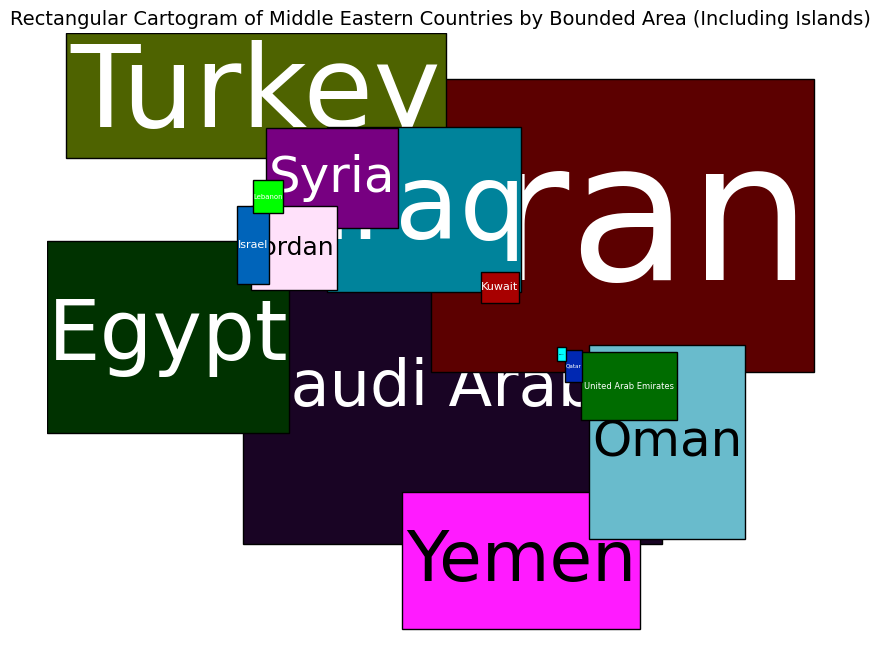

In [10]:

# Create a rectangular cartogram of middle eastern countries by bounded area (including islands)
import matplotlib.patches as patches
import webcolors

# Create the cartogram
fig, ax = plt.subplots(figsize=(12, 8))

# Initialize a base zorder for rectangles
base_zorder = 1

# Loop through countries and their properties
for (country_name, country_area) in country_areas:
    mask_series = countries_df.NAME_EN.isin([country_name])
    for (country_name, geometry), df in countries_df[mask_series].groupby(['NAME_EN', 'geometry']):
        bounds_tuple = geometry.bounds
            
        # Bounds Breakdown:
        minx = bounds_tuple[0]
        miny = bounds_tuple[1]
        maxx = bounds_tuple[2]
        maxy = bounds_tuple[3]
        
        # Rectangle Parameters:
        lower_left_corner = (minx, miny)
        width = maxx - minx
        height = maxy - miny
        
        # Add rectangle with current zorder
        facecolor = hex_color_dict[country_name]
        rect = patches.Rectangle(
            lower_left_corner, width, height,
            edgecolor="black",
            facecolor=facecolor,
            zorder=base_zorder,  # Current zorder for rectangle
        )
        ax.add_patch(rect)
    
        # Add country name with higher zorder than the rectangle
        rgb_tuple = tuple(webcolors.hex_to_rgb(facecolor))
        ax.text(
            minx + width / 2, miny + height / 2, country_name,
            alpha=1.0,
            color=nu.get_text_color(
                bar_color_rgb=rgb_tuple,
                readable_colors=['black', '#080808', 'white']
            ),
            fontsize=fontsize_dict[country_name],
            ha="center",
            va="center",
            zorder=base_zorder + 1,  # Higher than the current rectangle
        )

        # Increment base zorder for the next rectangle
        base_zorder += 1

# Adjust plot limits
mask_series = countries_df.NAME_EN.isin(country_names)
xlim_minx = countries_df[mask_series].geometry.map(lambda g: g.bounds[0]).min()
xlim_maxx = countries_df[mask_series].geometry.map(lambda g: g.bounds[2]).max()
ax.set_xlim(xlim_minx, xlim_maxx+1)
ylim_miny = countries_df[mask_series].geometry.map(lambda g: g.bounds[1]).min()
ylim_maxy = countries_df[mask_series].geometry.map(lambda g: g.bounds[3]).max()
ax.set_ylim(ylim_miny-1, ylim_maxy)
ax.set_aspect("equal")
plt.title("Rectangular Cartogram of Middle Eastern Countries by Bounded Area (Including Islands)", fontsize=14)
plt.axis("off")
plt.show()